In [1]:
%config Completer.use_jedi = False # use autocompletion

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import detectron2
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer
# import PyCOCO tools
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

setup_logger()

<Logger detectron2 (DEBUG)>

## Inference and submission

There are two minor details we need to handle:
- The submission notebooks don't have access to the internet, in order to install detectron2 I needed to download dependecies with `pip download`, put them into a dataset and attach it to the notebook: https://www.kaggle.com/slawekbiel/detectron-05
- The masks we submit can't overlap, see [the discussion](https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/279790#1550666). So I'm manually clipping the output returned from the model) I'm processing the masks ordereded by score, so in the case of conflict the more confident one remaines whole and the other one gets clipped.

In [2]:
# From https://www.kaggle.com/stainsby/fast-tested-rle
def rle_decode(mask_rle, shape=(520, 704)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def get_masks(fn, predictor):
    im = cv2.imread(str(fn))
    pred = predictor(im)
    pred_class = torch.mode(pred['instances'].pred_classes)[0]
    take = pred['instances'].scores >= THRESHOLDS[pred_class]
    pred_masks = pred['instances'].pred_masks[take]
    pred_masks = pred_masks.cpu().numpy()
    res = []
    used = np.zeros(im.shape[:2], dtype=int) 
    for mask in pred_masks:
        mask = mask * (1-used)
        if mask.sum() >= MIN_PIXELS[pred_class]: # skip predictions with small area
            used += mask
            res.append(rle_encode(mask))
    return res

In [4]:
dataDir=Path('sartorius-cell-instance-segmentation')

ids, masks=[],[]
# test_names = (dataDir/'test').ls()
PATHGLOB = Path(dataDir/'test').glob('./*')
test_names = [fil for fil in PATHGLOB]
test_names

[PosixPath('sartorius-cell-instance-segmentation/test/7ae19de7bc2a.png'),
 PosixPath('sartorius-cell-instance-segmentation/test/d8bfd1dafdc4.png'),
 PosixPath('sartorius-cell-instance-segmentation/test/d48ec7815252.png')]

### Initiate a Predictor from our trained model

In [68]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
cfg.MODEL.WEIGHTS = os.path.join('./output', "model_best.pth")  
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
predictor = DefaultPredictor(cfg)
THRESHOLDS = [.25, .35, .35]
MIN_PIXELS = [20, 65, 40]

### Look at the outputs on a sample test file to sanity check
I'm encoding here in the competition format and decoding back to bit mask just to make sure everything is fine

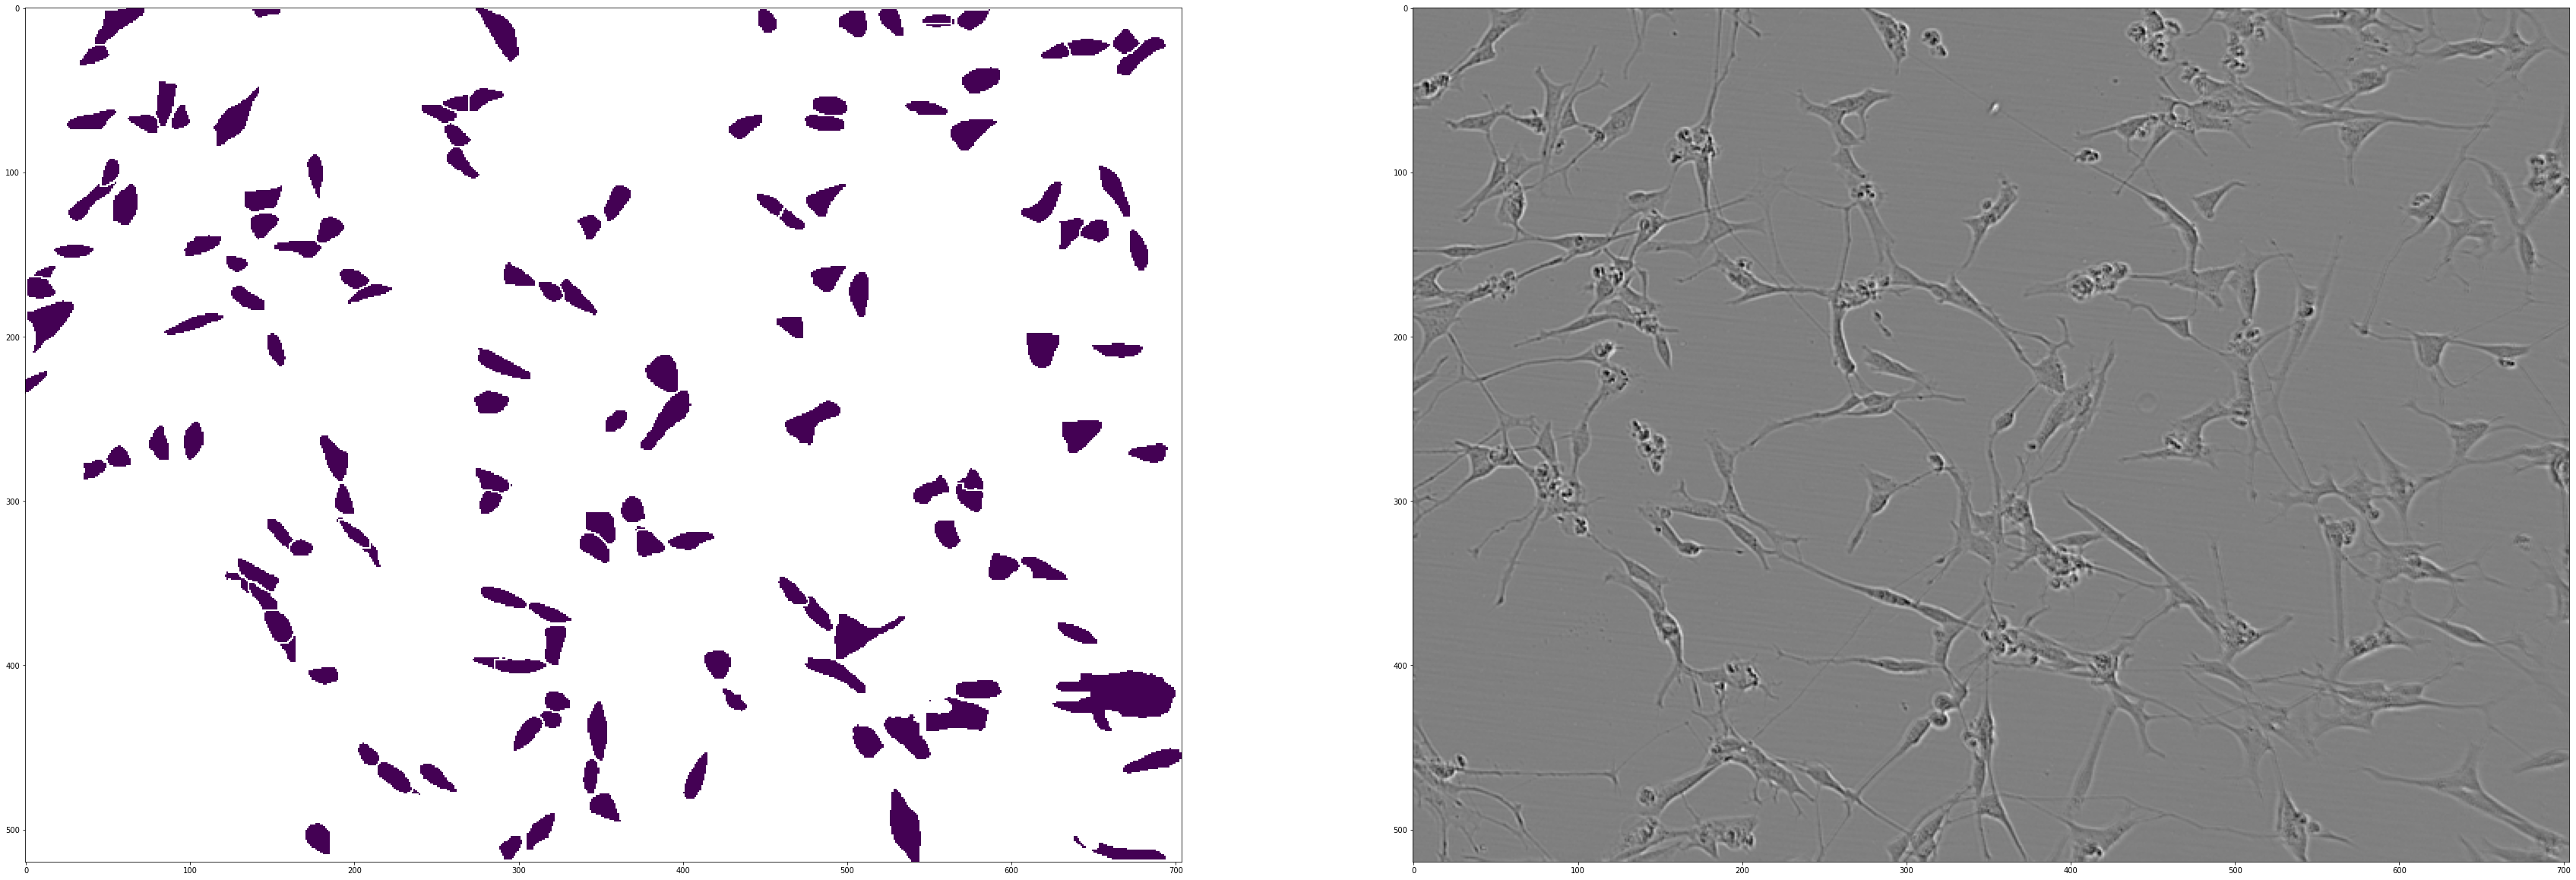

In [57]:
encoded_masks = get_masks(test_names[0], predictor)

_, axs = plt.subplots(1,2, figsize=(60,25))
axs[1].imshow(cv2.imread(str(test_names[0])))
for enc in encoded_masks:
    dec = rle_decode(enc)
    axs[0].imshow(np.ma.masked_where(dec==0, dec))

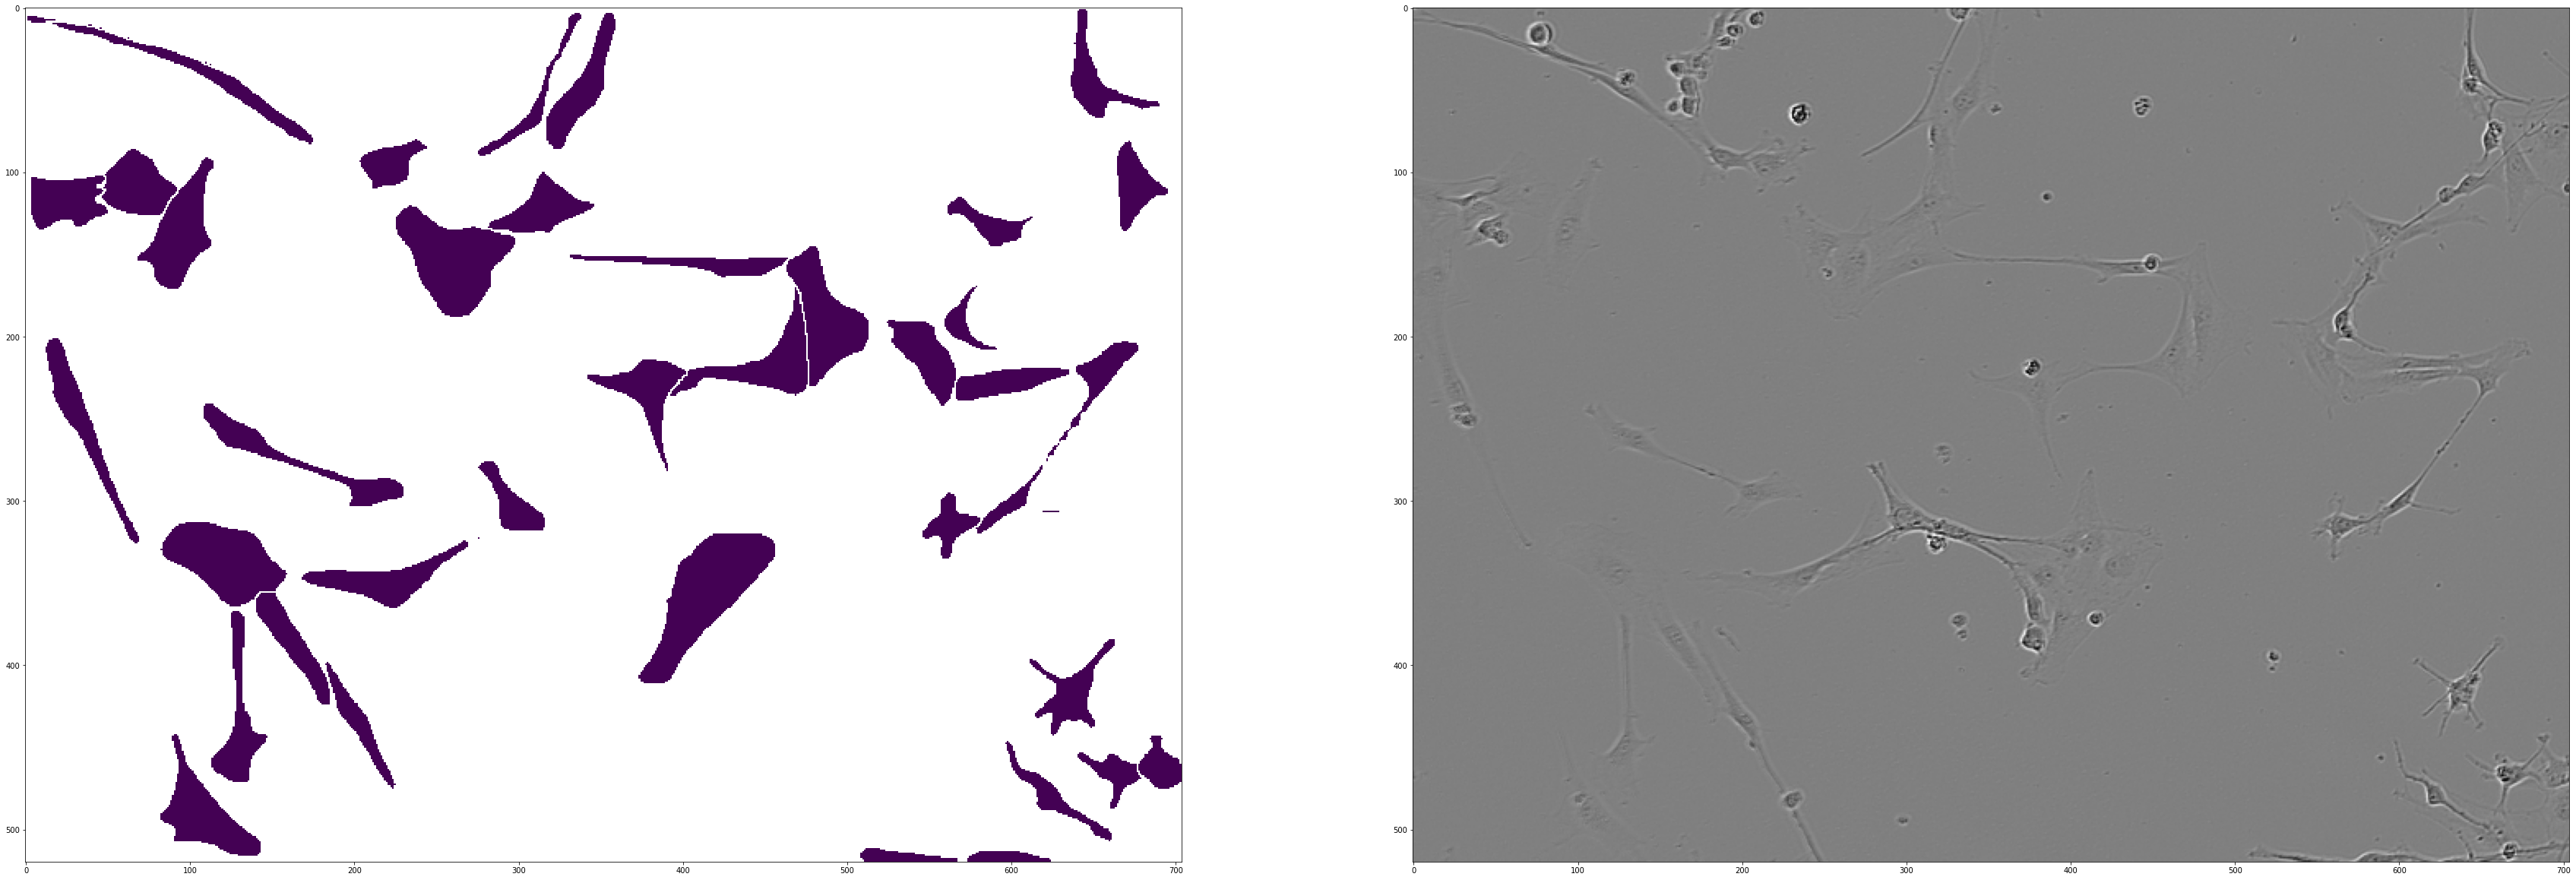

In [59]:
encoded_masks = get_masks(test_names[2], predictor)

_, axs = plt.subplots(1,2, figsize=(60,25))
axs[1].imshow(cv2.imread(str(test_names[2])))
for enc in encoded_masks:
    dec = rle_decode(enc)
    axs[0].imshow(np.ma.masked_where(dec==0, dec))

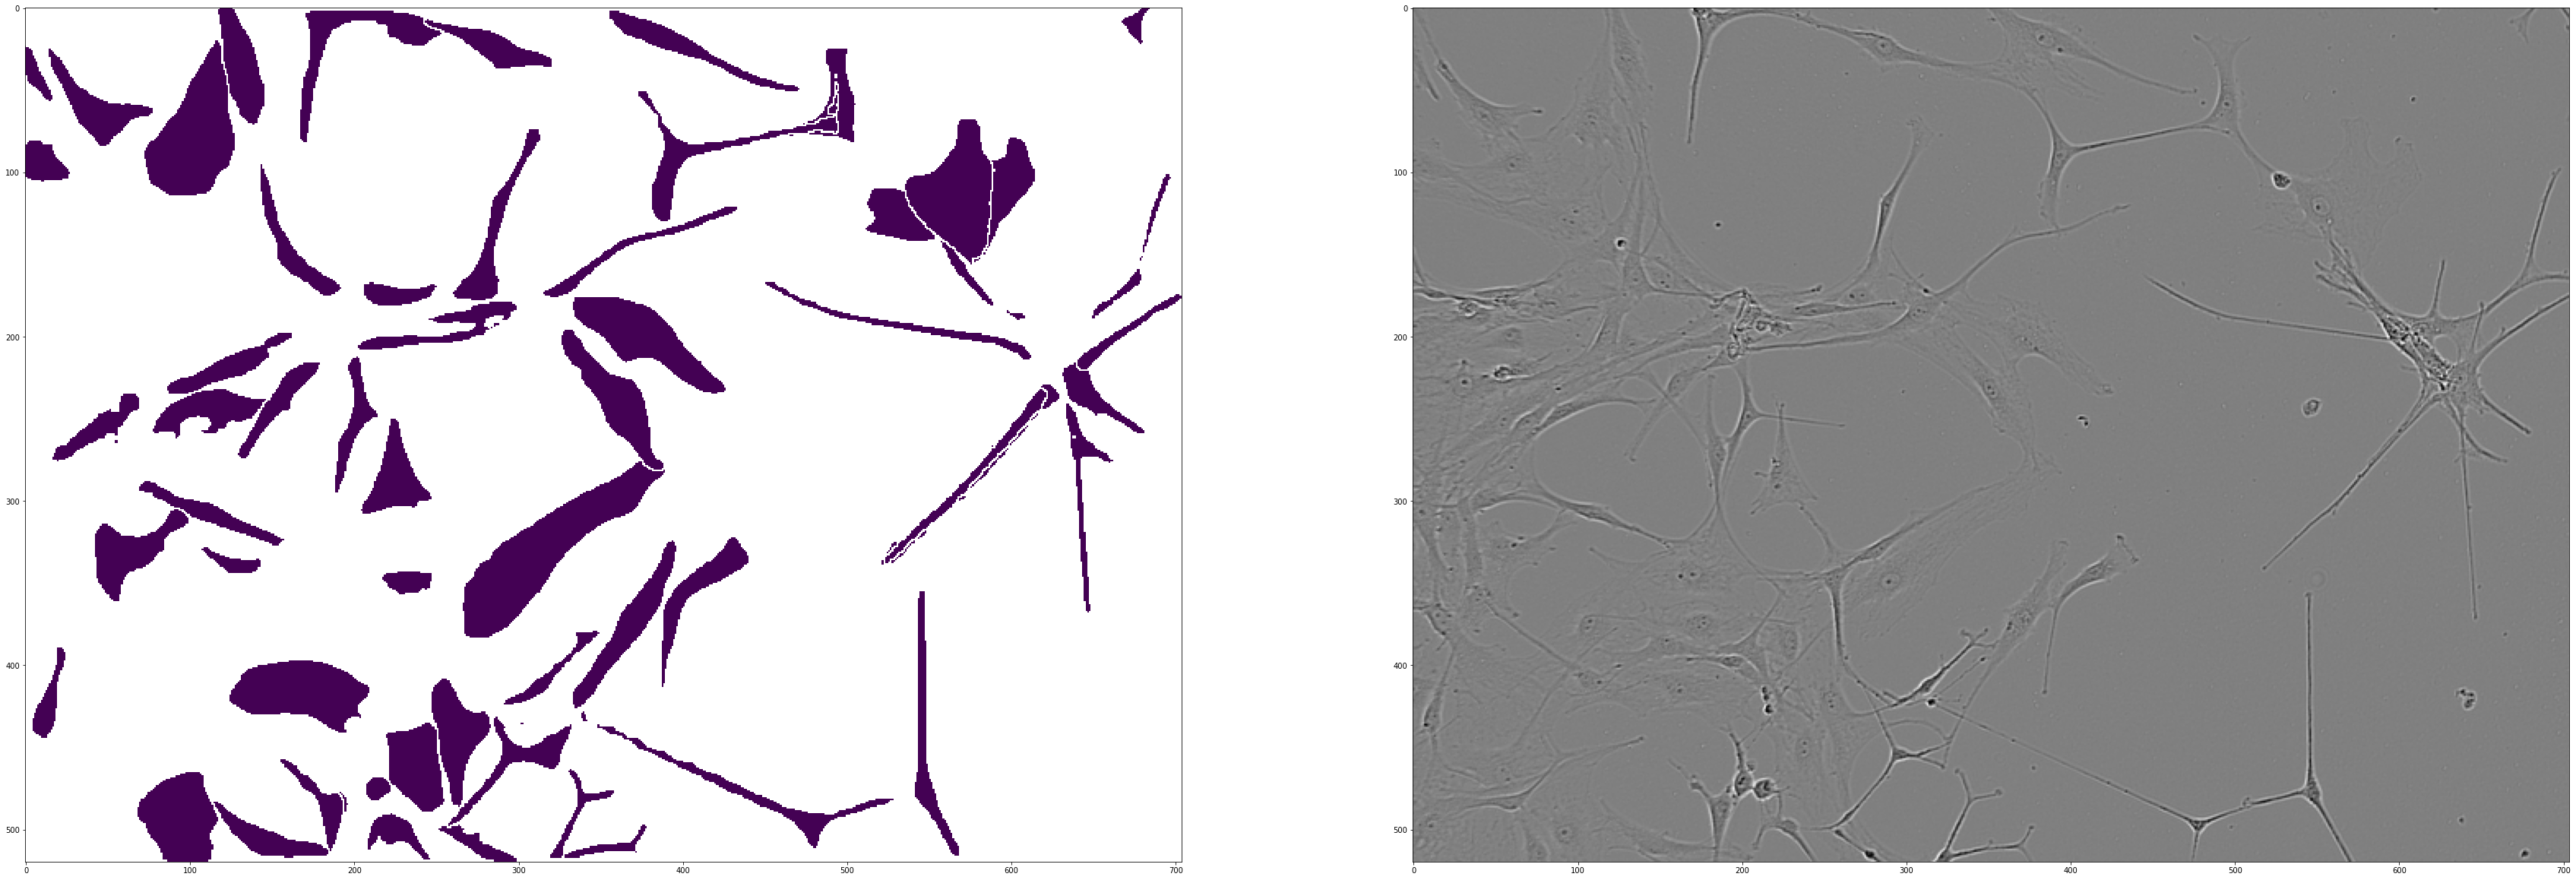

In [69]:
encoded_masks = get_masks(test_names[1], predictor)

_, axs = plt.subplots(1,2, figsize=(60,25))
axs[1].imshow(cv2.imread(str(test_names[1])))
for enc in encoded_masks:
    dec = rle_decode(enc)
    axs[0].imshow(np.ma.masked_where(dec==0, dec))

### Looks good, so lets generate masks for all the files and create a submission

In [ ]:
for fn in test_names:
    encoded_masks = get_masks(fn, predictor)
    for enc in encoded_masks:
        ids.append(fn.stem)
        masks.append(enc)

In [ ]:
pd.DataFrame({'id':ids, 'predicted':masks}).to_csv('submission.csv', index=False)
pd.read_csv('submission.csv').head()